In [1]:
.libPaths(c("~/Cellchat_Rlibs", .libPaths()))

In [2]:
source("../Utility/seurat_tools.r")
source("../Utility/plots.r")
source("../Utility/markers_utility.r")
source("../Utility/enrichment.r")
source("../Utility/cell_cycle_scoring.r")

In [13]:
library(Seurat)
library(qs)
library(ggplot2)
library(ggbeeswarm)
library(dplyr)
library(stringr)
library(reshape2)
library(ggplot2)

In [9]:
seurat_obj <- qread("../Step5_Clustering/out/SCPCP000001/annotated_harmony_SCPCP000001_50_2000_3000.qs")
cellchat <- qread("../Step8_Cellchat/out/cellchat.qs")
pyscenic_rss <- qread("../Step9_Pyscenic/out/pyscenic_rss.qs")
motifEnrichmentFile <- file.path("../Step9_Pyscenic/out/regulons.csv")
motifEnrichment <- data.table::fread(motifEnrichmentFile, header=T, skip=1)[-3,]
colnames(motifEnrichment)[1:2] <- c("TF", "MotifID")

In [66]:
cell_order=c("T cells",
            "NK cells",
            "Naive B",
            "MGD TAM",
            "MGD Macrophage",
            "MD Macrophage",
            "Undetermined",
            "MES-APC-like",
            "MES-AC-like",
            "MES-AC-like Cycling",
            "OPC-like"
)

seurat_obj$cell_label <- factor(seurat_obj$cell_label, levels = cell_order)
seurat_obj <- SetIdent(seurat_obj, value = "cell_label")


## Base umap

## SPP1 TF activity Heatmap

In [10]:
rss_df <- as.data.frame(pyscenic_rss)

In [ ]:
subset_with_spp1 <- motifEnrichment[grepl("SPP1", motifEnrichment$TargetGenes), ]
motifEnrichment_cleaned_spp1 <- subset_with_spp1 %>%
  mutate(TargetGenes = str_extract_all(TargetGenes, "[A-Za-z0-9\\-]+")) %>%  
  mutate(TargetGenes = lapply(TargetGenes, function(x) {
    x_clean <- x[!grepl("^\\d+(\\.\\d+)?([eE][-+]?\\d+)?$", x)] 
    x_sorted <- sort(x_clean) 
    paste(x_sorted, collapse = ";")
  })) 

motifEnrichment_cleaned_spp1 <- motifEnrichment_cleaned_spp1 %>% arrange(desc(AUC))
rss_df_spp1 <- rss_df[gsub("\\(.*\\)", "", rownames(rss_df)) %in% motifEnrichment_cleaned_spp1$TF, ]
rss_df_spp1$TF <- gsub("\\(.*\\)", "", rownames(rss_df_spp1))
rownames(rss_df_spp1) <- rss_df_spp1$TF
clusters <- colnames(rss_df_spp1)[-ncol(rss_df_spp1)] 
cor_matrix <- matrix(NA, nrow = nrow(rss_df_spp1), ncol = length(clusters))
rownames(cor_matrix) <- rownames(rss_df_spp1)
colnames(cor_matrix) <- clusters
for (cl in clusters) {
    cells_in_cl <- WhichCells(seurat_obj, idents = cl) 
    spp1_expr <- FetchData(seurat_obj, vars = "SPP1")[cells_in_cl, , drop = FALSE]
    for (i in 1:nrow(rss_df_spp1)) {
        tf <- rownames(rss_df_spp1)[i]
        if (tf %in% rownames(seurat_obj)) {
            tf_expr <- FetchData(seurat_obj, vars = tf)[cells_in_cl, , drop = FALSE]
            cor_val <- cor(tf_expr[[tf]], spp1_expr[["SPP1"]], method = "spearman")
            cor_matrix[tf, cl] <- cor_val
        }
    }
}
head(cor_matrix)

Warning message in cor(tf_expr[[tf]], spp1_expr[["SPP1"]], method = "spearman"):
“the standard deviation is zero”
Warning message in cor(tf_expr[[tf]], spp1_expr[["SPP1"]], method = "spearman"):
“the standard deviation is zero”


,MD Macrophage,NK cells,MGD Macrophage,MES-AC-like,T cells,OPC-like,MES-AC-like Cycling,MES-APC-like,MGD TAM,Naive B,Undetermined
KLF12,-0.114475395,-0.06996383,0.03605168,-0.04606202,-0.010698832,-0.03456889,-0.057011675,-0.11837920,-0.08941132,0.18695522,-0.094624323
MAFB,0.201581674,-0.05368043,-0.01246748,0.09065516,0.133432517,0.01197671,0.078728151,0.06260768,-0.10990493,0.15680639,0.185030253
NFIB,0.075471614,-0.03781374,0.07180831,0.03142097,-0.026294325,0.17547064,0.003733517,-0.04517459,0.07812058,-0.05040205,-0.136506130
RFX3,0.042303894,0.01792724,-0.03342911,0.02210850,0.021854607,0.25266616,-0.062526084,-0.02694376,-0.10192336,-0.06453571,0.002536025
TEAD1,0.001481078,-0.06599592,0.07817686,0.03844061,-0.000908532,0.06762555,-0.047968219,-0.04370935,0.03554193,NA,-0.179854889
THRB,0.073051663,NA,-0.02652748,-0.01116963,-0.022785127,-0.06519867,-0.011711372,-0.06091050,-0.05388129,-0.10515227,0.164559825


In [ ]:
#clust_of_interest <- c("MGD TAM","MGD Macrophage","MD Macrophage","OPC-like","Undetermined")

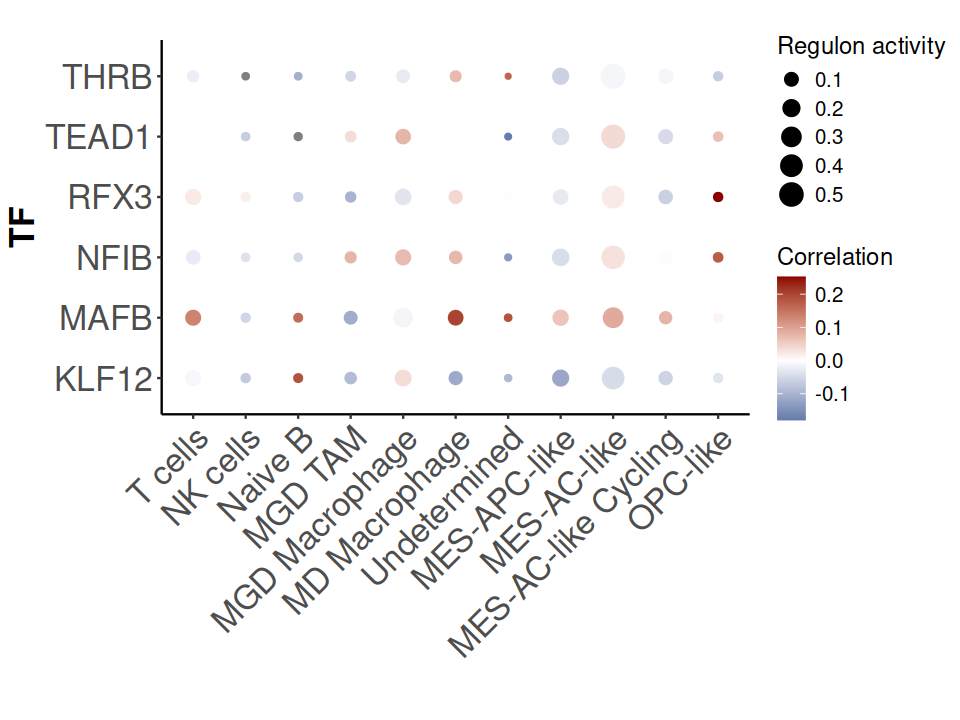

In [150]:
options(repr.plot.width=8, repr.plot.height=6)

rss_long <- melt(as.matrix(rss_df_spp1[,clusters]))  
rss_long <- melt(as.matrix(rss_df_spp1[,clusters]))  
colnames(rss_long) <- c("TF", "Cluster", "Regulon activity")
cor_long <- melt(cor_matrix)
colnames(cor_long) <- c("TF", "Cluster", "Correlation")
dot_df <- left_join(rss_long, cor_long, by = c("TF", "Cluster"))
dot_df <- dot_df[order(dot_df$Correlation, decreasing = TRUE),]

dot_df$Cluster <- factor(dot_df$Cluster, levels = cell_order)
#dot_df <- subset(dot_df, subset=(Cluster %in% clust_of_interest))

p <- ggplot(dot_df, aes(x = Cluster, y = TF)) +
  geom_point(aes(size = `Regulon activity`, color = Correlation)) +
  scale_color_gradient2(low = "dodgerblue4", mid = "white", high = "darkred", midpoint = 0) +
  scale_size_continuous(range = c(1, 6)) +
  theme_classic() +
  theme(axis.text.x = element_text(size = 20, angle = 45, hjust = 1),
        axis.title.x = element_text(face = "bold", size = 20),
        axis.text.y = element_text(size = 20),
        axis.title.y = element_text(face = "bold", size = 20),
        legend.text = element_text(size = 12),      
        legend.title = element_text(size = 14))  +
  labs(title = "", 
       x = "", 
       y = "TF");

ggsave("./out/fig3/TF_rss_correlation.png", p, height=6, width=8, dpi=600, create.dir = TRUE)
p

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


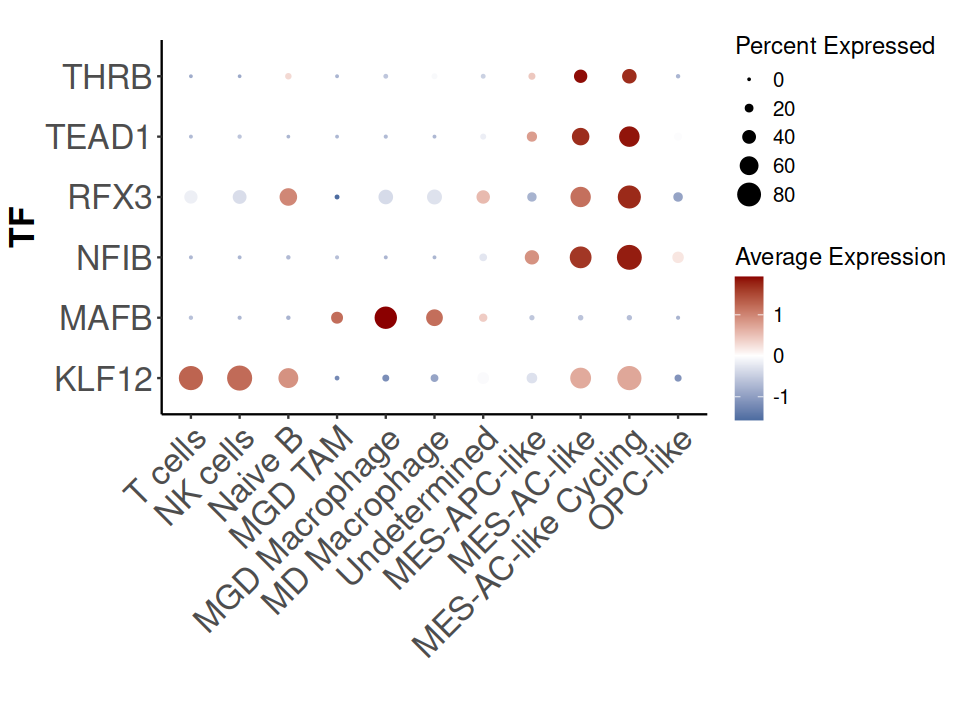

In [151]:
options(repr.plot.width=8, repr.plot.height=6)


TFs <- rownames(cor_matrix) 
p <- DotPlot(seurat_obj, 
                features = TFs, 
                 group.by = "cell_label", 
                 cols = c("dodgerblue4","white","darkred"),
                ) +
            scale_colour_gradient2(low = "dodgerblue4", mid = "white", high = "darkred") +
            theme_classic() +
            labs(y = "Cell type", x="TF") +
                theme(
                     axis.text.x = element_text(size = 20, angle = 45, hjust = 1),
                    axis.title.x = element_text(face = "bold", size = 20),
                    axis.text.y = element_text(size = 20),
                    axis.title.y = element_text(face = "bold", size = 20),
                     legend.text = element_text(size = 12),      
                     legend.title = element_text(size = 14)) +
              labs(title = "", x = "TF", y = "") +
            coord_flip()

p

ggsave("./out/fig3/dotplot_TFs.png", p, dpi=600, height=6, width=8, create.dir = TRUE)


In [96]:
SSP1_regulon_subset <- subset(seurat_obj, subset=(cell_label %in% clust_of_interest))

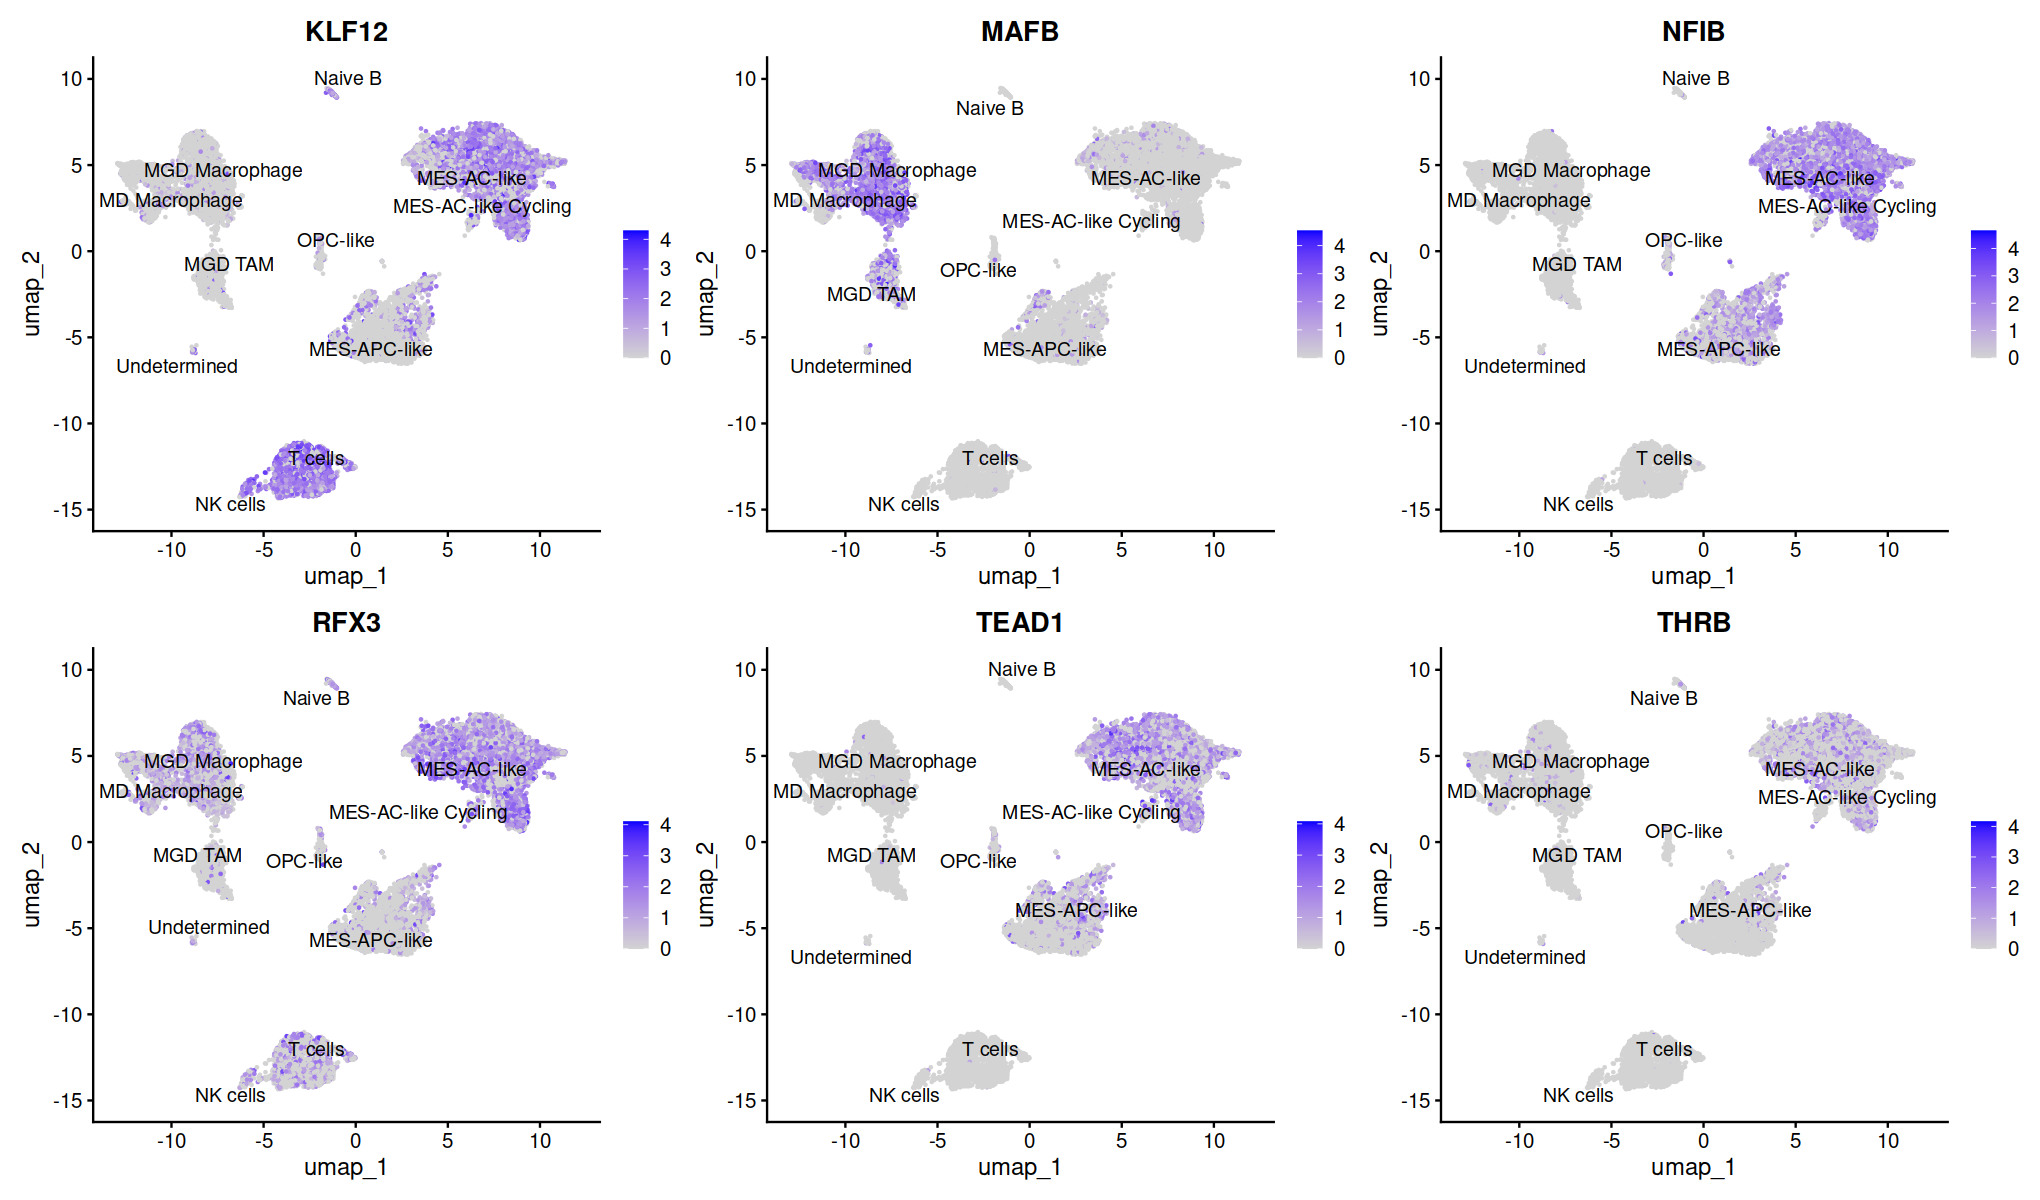

In [110]:
options(repr.plot.width=17, repr.plot.height=10)

features <- rownames(cor_matrix)
p <- FeaturePlot(object = seurat_obj, features = features, label=TRUE, label.size = 4, repel=TRUE, ncol=3)
ggsave("./out/fig3/TF_rss_featureplot.png", p, width=17, height=10, dpi=600, create.dir = TRUE)
p

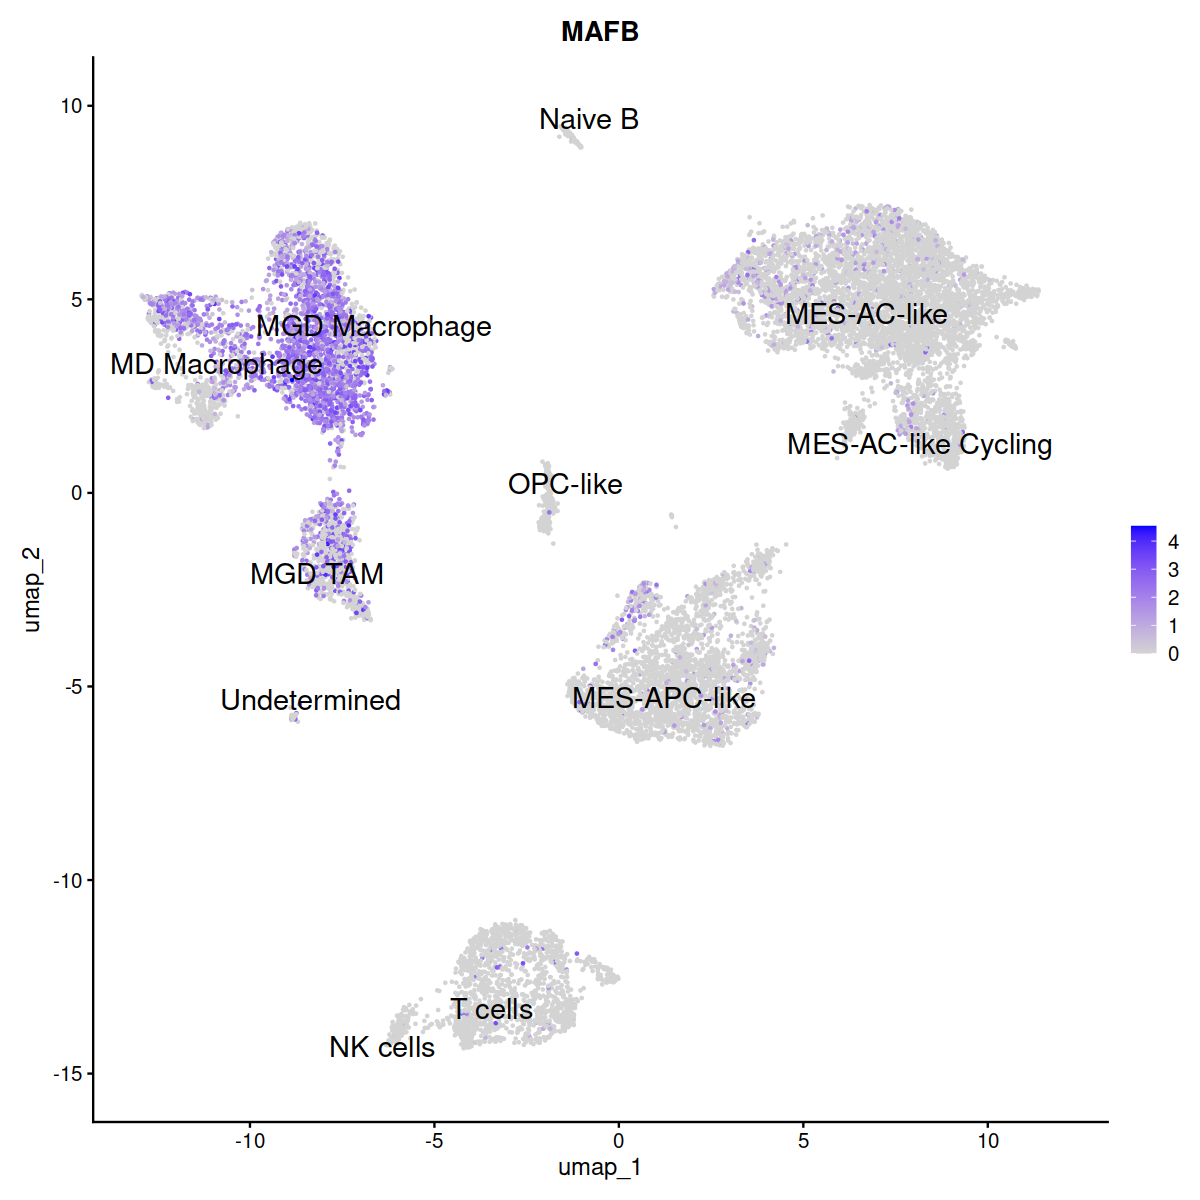

In [122]:
options(repr.plot.width=10, repr.plot.height=10)

p <- FeaturePlot(object = seurat_obj, features = "MAFB", label=TRUE, label.size = 6, repel=TRUE, ncol=1)
ggsave("./out/fig3/MAFB_featureplot.png", p, width=9, height=8, dpi=600, create.dir = TRUE)
p

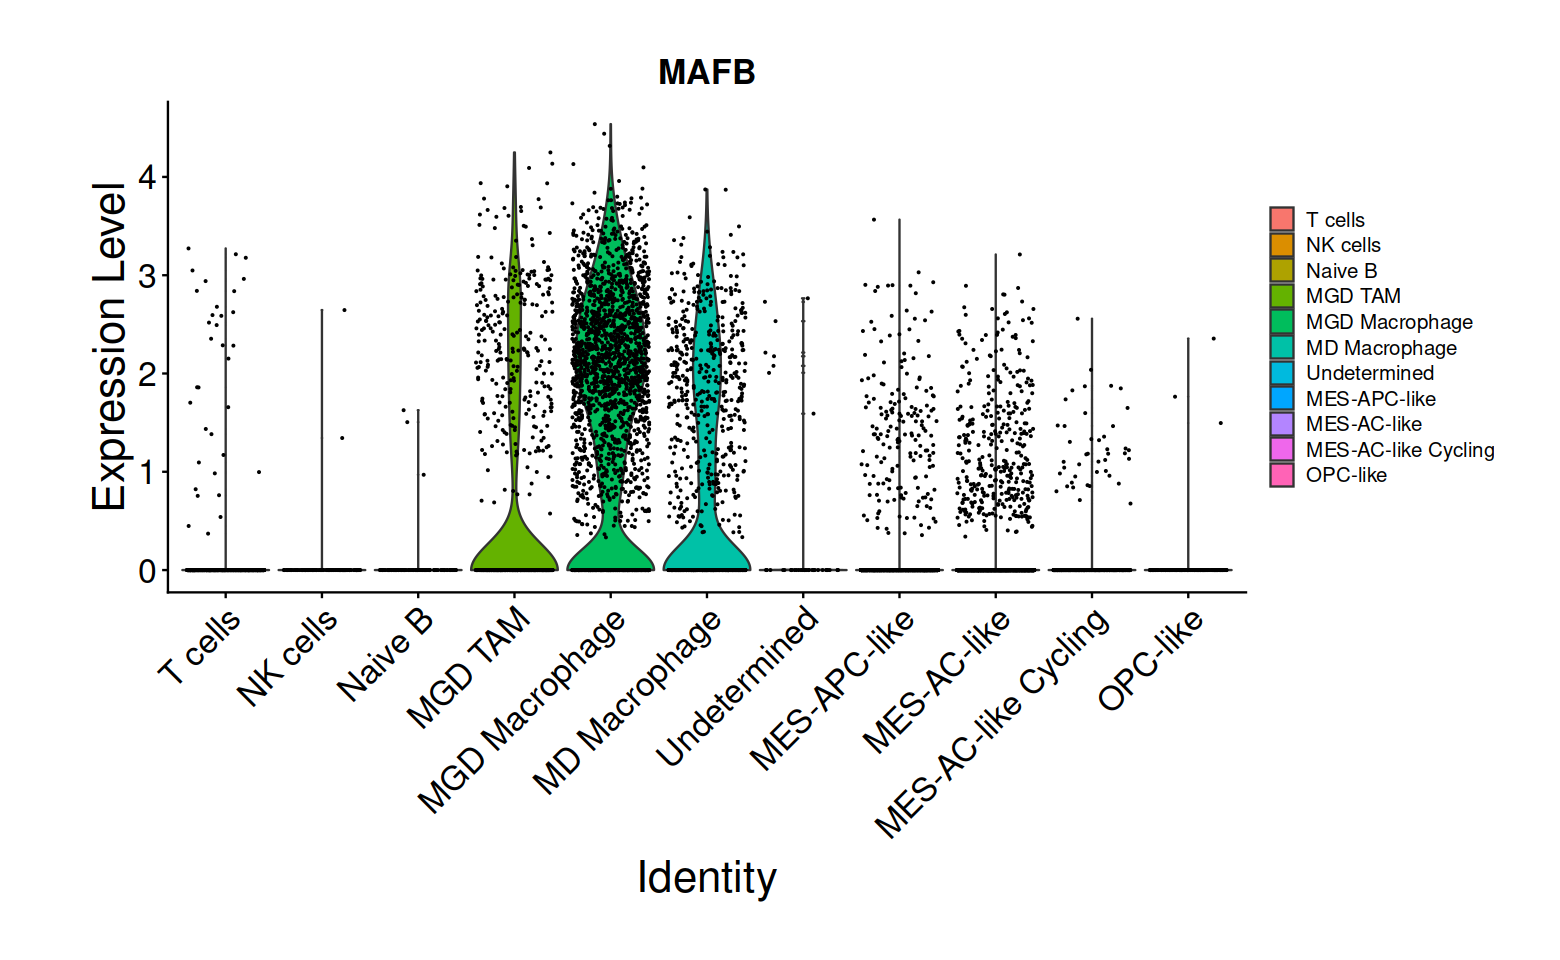

In [152]:
options(repr.plot.width=13, repr.plot.height=8)
p <- VlnPlot(seurat_obj, features = "MAFB")
p <- p + theme(
  plot.title = element_text(size = 20, face = "bold"),
  axis.title.x = element_text(size = 26),
  axis.title.y = element_text(size = 26),
  axis.text.x = element_text(size = 20),
  axis.text.y = element_text(size = 20),
  plot.margin = margin(t = 30, r = 30, b = 30, l = 50)
)
ggsave("./out/fig3/MAFB_violin.png", p, dpi=600, width=13, height=6)
p

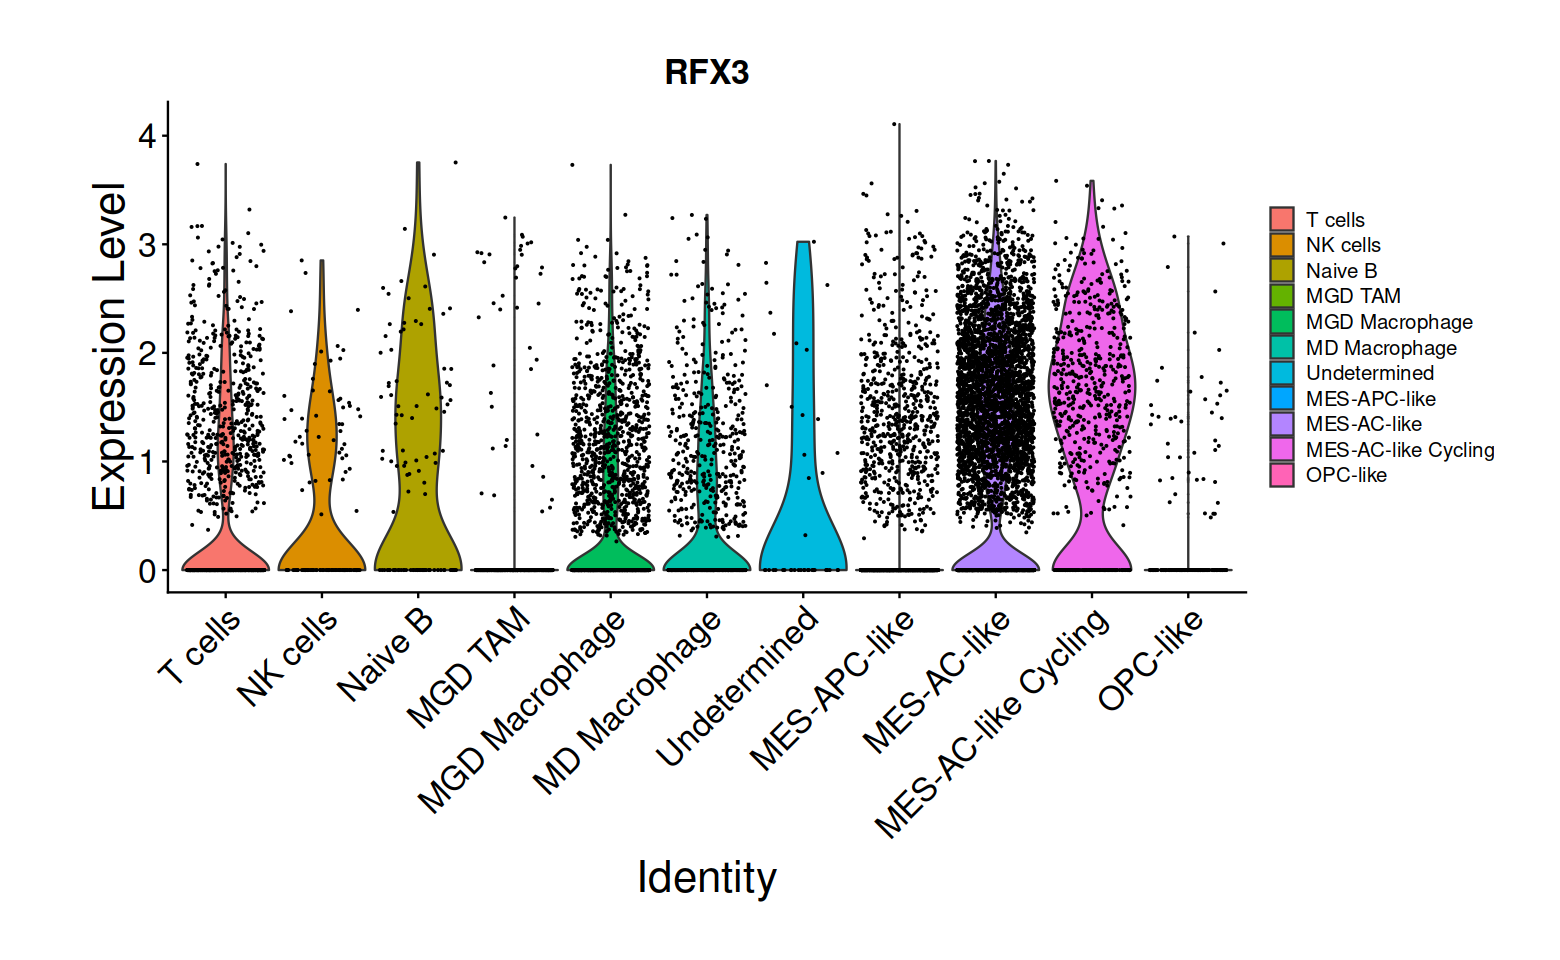

In [108]:
options(repr.plot.width=13, repr.plot.height=8)
p <- VlnPlot(seurat_obj, features = "RFX3")
p <- p + theme(
  plot.title = element_text(size = 20, face = "bold"),
  axis.title.x = element_text(size = 26),
  axis.title.y = element_text(size = 26),
  axis.text.x = element_text(size = 20),
  axis.text.y = element_text(size = 20),
  plot.margin = margin(t = 30, r = 30, b = 30, l = 50)
)
ggsave("./out/fig3/RFX3_violin.png", p, dpi=600, width=13, height=8)
p